In [75]:
"""
📊 Project Title: Stock Market Prediction using LSTM

🔍 Overview:
This project aims to predict the **closing stock price** for major technology companies using a Long Short-Term Memory (LSTM) neural network. It leverages historical market data and advanced technical indicators to capture market behavior patterns and enhance predictive accuracy.

📅 Data Source:
- Yahoo Finance (`yfinance` API)
- Companies: Apple (AAPL), Amazon (AMZN), Google (GOOGL), Microsoft (MSFT), Tesla (TSLA)
- Timeframe: January 1, 2015 – January 1, 2025

🧮 Features:
- Over 15 engineered features including technical indicators like RSI, MACD, SMA, Bollinger Bands, Stochastic Oscillator, OBV, ATR, ROC, and lag values.
- These indicators capture momentum, volatility, trend strength, and volume-related insights to help the model understand market dynamics.

🧠 Model:
- **LSTM (Long Short-Term Memory)** is chosen for its strength in capturing time-based dependencies and long-range trends in sequential financial data.

🎯 Why LSTM?
LSTM networks are ideal for time-series forecasting because they:
- Handle long-term dependencies better than traditional RNNs
- Maintain memory of past inputs without vanishing gradients
- Improve performance on noisy, non-linear financial data

📈 Goal:
To build a robust, scalable deep learning model that can accurately predict closing prices and assist in strategic investment decision-making.

"""


'\n📊 Project Title: Stock Market Prediction using LSTM\n\n🔍 Overview:\nThis project aims to predict the **closing stock price** for major technology companies using a Long Short-Term Memory (LSTM) neural network. It leverages historical market data and advanced technical indicators to capture market behavior patterns and enhance predictive accuracy.\n\n📅 Data Source:\n- Yahoo Finance (`yfinance` API)\n- Companies: Apple (AAPL), Amazon (AMZN), Google (GOOGL), Microsoft (MSFT), Tesla (TSLA)\n- Timeframe: January 1, 2015 – January 1, 2025\n\n🧮 Features:\n- Over 15 engineered features including technical indicators like RSI, MACD, SMA, Bollinger Bands, Stochastic Oscillator, OBV, ATR, ROC, and lag values.\n- These indicators capture momentum, volatility, trend strength, and volume-related insights to help the model understand market dynamics.\n\n🧠 Model:\n- **LSTM (Long Short-Term Memory)** is chosen for its strength in capturing time-based dependencies and long-range trends in sequential 

In [76]:
!pip install yfinance

In [77]:
#Data Handeling
#Fetch historical stock data from Yahoo Finance

In [78]:
import yfinance as yf
import pandas as pd

tickers = ["AAPL", "AMZN", "GOOGL", "MSFT", "TSLA"]
start_date = "2015-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker", auto_adjust=False)

data = data.stack(level=0).reset_index()
data.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

print(data.head())
print(data.columns)


[*********************100%***********************]  5 of 5 completed

        Date Ticker       Open       High        Low      Close  Adj Close  \
0 2015-01-02   AAPL  27.847500  27.860001  26.837500  27.332500  24.320431   
1 2015-01-02   AMZN  15.629000  15.737500  15.348000  15.426000  15.426000   
2 2015-01-02  GOOGL  26.629999  26.790001  26.393999  26.477501  26.351515   
3 2015-01-02   MSFT  46.660000  47.419998  46.540001  46.759998  40.072136   
4 2015-01-02   TSLA  14.858000  14.883333  14.217333  14.620667  14.620667   

      Volume  
0  212818400  
1   55664000  
2   26480000  
3   27913900  
4   71466000  
Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object')



C:\Users\User\AppData\Local\Temp\ipykernel_14256\2429518543.py:10: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [79]:
# Taking care of missing data

In [80]:
print(data.isnull().sum())

Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [81]:
data['Ticker'] = data['Ticker'].astype('category')
print(data.dtypes)

Date         datetime64[ns]
Ticker             category
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [82]:
#data visualization

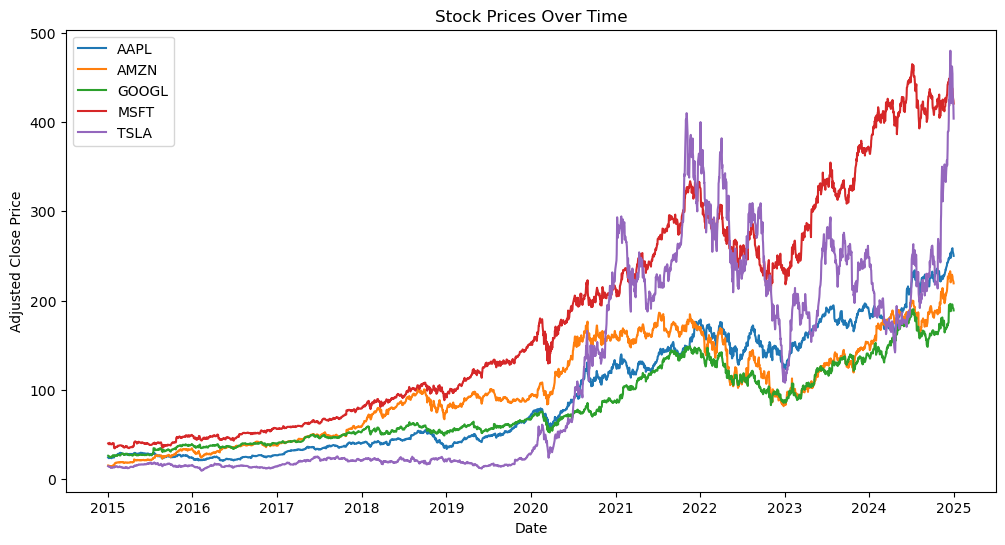

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for ticker in data['Ticker'].unique():
    subset = data[data['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [84]:
#Pattern detection: Helps identify trends and cyclic behavior in stock prices.

#Stationarity check: Assists in determining if a time series is stationary or needs transformation.

#Model guidance: Helps in selecting the right forecasting model (AR, MA, or ARMA).

#Volatility insights: Provides insights into a stock’s price stability and volatility.

#Cross-stock comparison: Allows you to compare the correlation behavior of different stocks.

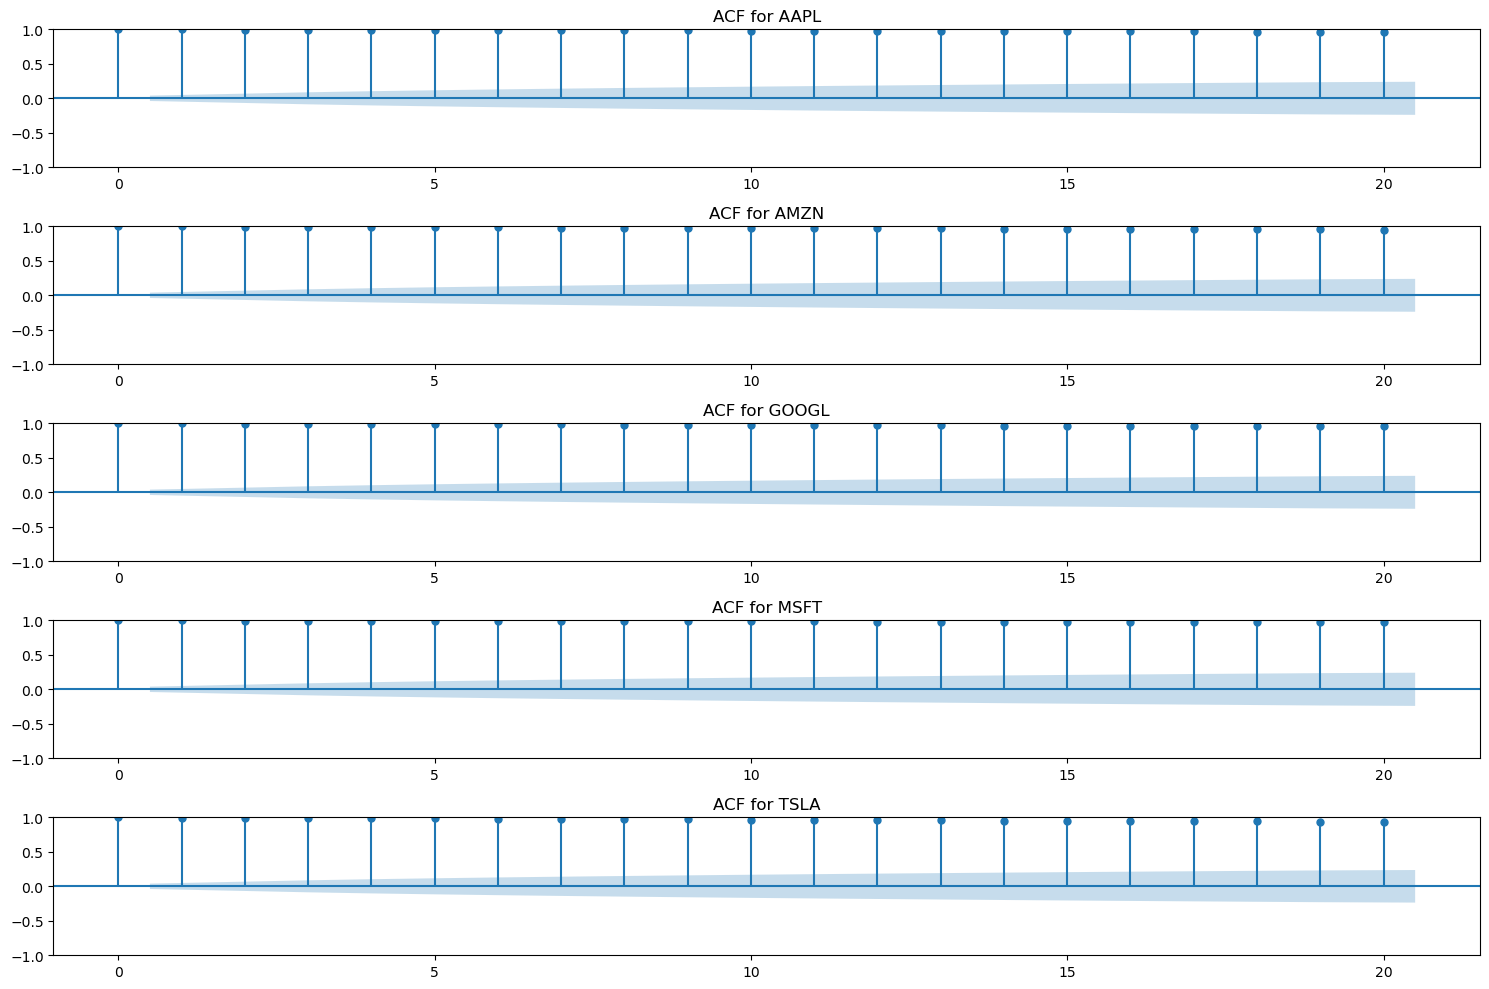

In [85]:
from statsmodels.graphics.tsaplots import plot_acf

tickers = data['Ticker'].unique()
plt.figure(figsize=(15, 10))

for i, ticker in enumerate(tickers, 1):
    plt.subplot(len(tickers), 1, i) 
    subset = data[data['Ticker'] == ticker]['Adj Close']
    plot_acf(subset, lags=20, ax=plt.gca())  
    plt.title(f"ACF for {ticker}")

plt.tight_layout()
plt.show()

In [86]:
# PACF (Partial Autocorrelation Function) helps identify how many lagged values (previous days' prices) directly influence the current stock price, 
# which is crucial for choosing the right lag features or configuring time series models like AR, ARIMA, or LSTM.

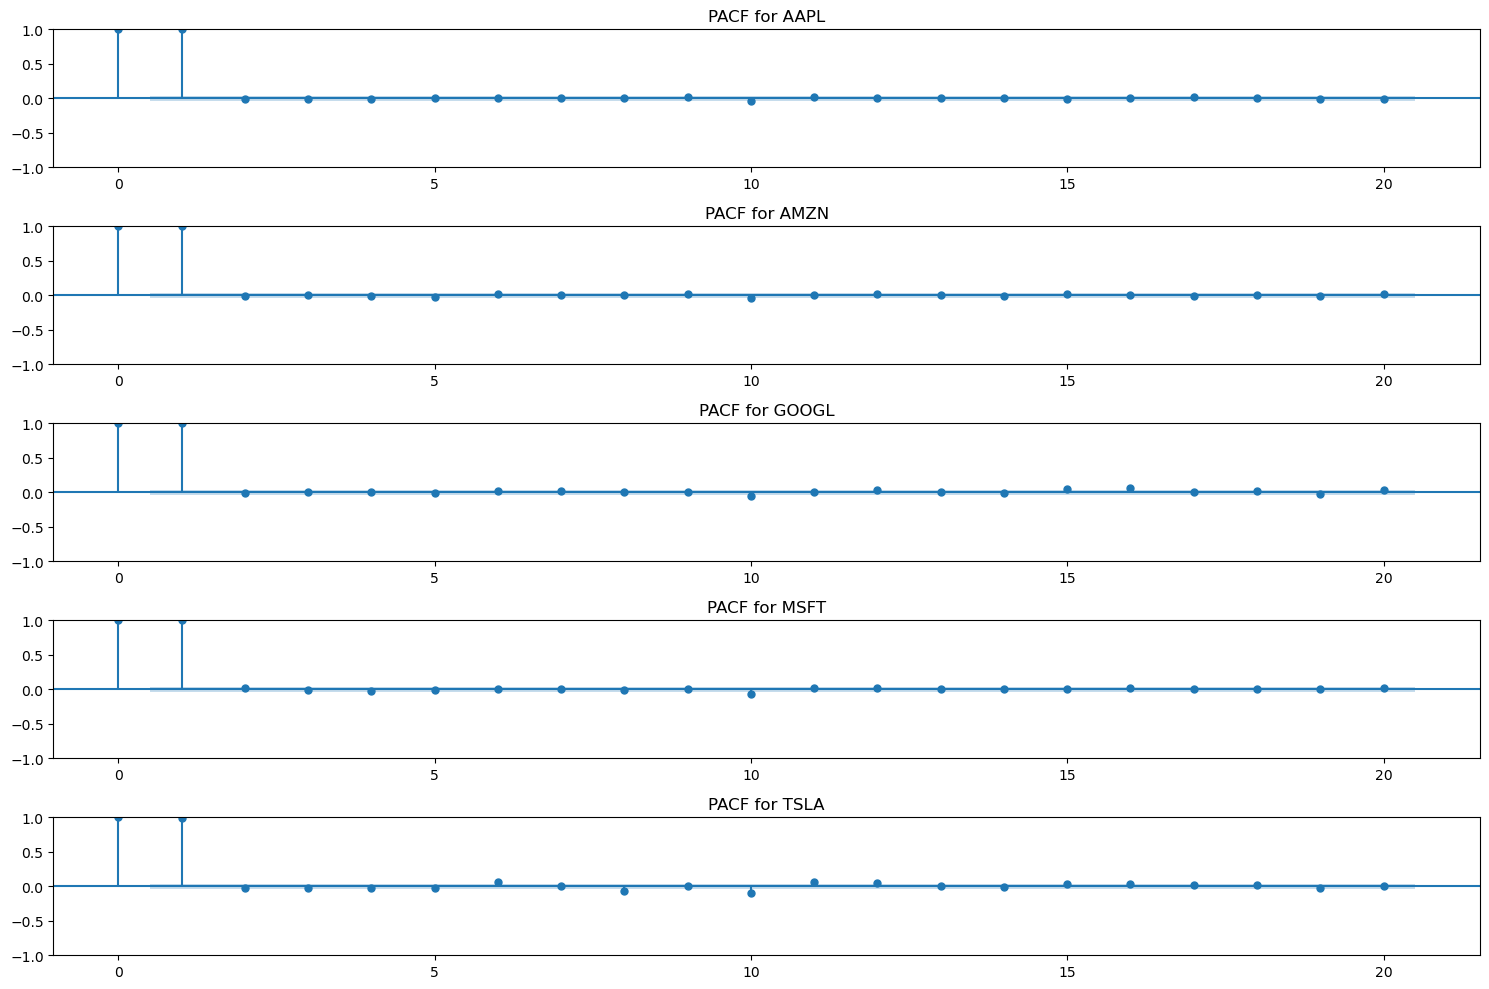

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15, 10))
for i, ticker in enumerate(data['Ticker'].unique(), 1):
    plt.subplot(len(tickers), 1, i)
    subset = data[data['Ticker'] == ticker]['Adj Close']
    plot_pacf(subset, lags=20, ax=plt.gca(), method='ywm')
    plt.title(f"PACF for {ticker}")

plt.tight_layout()
plt.show()

In [88]:
# Calculating the indicators (technical features)

In [89]:
import numpy as np
# Function to compute RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculating the indicators (technical features)
num_lags = 5
for lag in range(1, num_lags + 1):
    data[f'Adj Close_Lag_{lag}'] = data.groupby('Ticker')['Adj Close'].shift(lag)

data = data.dropna()

data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['STD_50'] = data['Close'].rolling(window=50).std()

data['ROC'] = data['Close'].pct_change()

data['RSI'] = compute_rsi(data['Close'])

short_ema = data.groupby('Ticker')['Adj Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
long_ema = data.groupby('Ticker')['Adj Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
data['MACD'] = short_ema - long_ema
data['Signal_Line'] = data.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

data['Volume_MA'] = data['Volume'].rolling(window=20).mean()

data['SMA_20'] = data.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=20).mean())
data['STD_20'] = data.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=20).std())
data['Upper_Band'] = data['SMA_20'] + (data['STD_20'] * 2)
data['Lower_Band'] = data['SMA_20'] - (data['STD_20'] * 2)

data['BB_Width'] = data['Upper_Band'] - data['Lower_Band']
data['BB_Percent'] = (data['Close'] - data['Lower_Band']) / (data['Upper_Band'] - data['Lower_Band'])
data['Volatility'] = data['Close'].rolling(window=20).std()

data['Volume_Lag_1'] = data['Volume'].shift(1)
data['RSI_Lag_1'] = data['RSI'].shift(1)

data['SMA_10'] = data['Adj Close'].rolling(window=10).mean()

low_14 = data.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=14).min())
high_14 = data.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=14).max())
data['Stochastic_%K'] = ((data['Adj Close'] - low_14) / (high_14 - low_14)) * 100
data['Stochastic_%D'] = data.groupby('Ticker')['Stochastic_%K'].transform(lambda x: x.rolling(window=3).mean())

data['Prev_Close'] = data.groupby('Ticker')['Adj Close'].shift(1)
data['TR'] = data[['High', 'Low', 'Prev_Close']].apply(lambda x: max(x[0] - x[1], abs(x[0] - x[2]), abs(x[1] - x[2])), axis=1)
data['ATR'] = data.groupby('Ticker')['TR'].transform(lambda x: x.ewm(span=14, adjust=False).mean())

def calculate_obv(group):
    obv = group['Volume'].where(group['Adj Close'].diff() > 0, -group['Volume']).cumsum()
    return obv

data['OBV'] = 0
for ticker, group in data.groupby('Ticker'):
    data.loc[group.index, 'OBV'] = calculate_obv(group)

data['RSI_14'] = compute_rsi(data['Adj Close'])

data[['RSI_14', 'Stochastic_%K', 'Stochastic_%D']] = data[['RSI_14', 'Stochastic_%K', 'Stochastic_%D']].fillna(method='ffill')
data[['SMA_10', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']] = data[['SMA_10', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']].fillna(method='ffill')
data['Prev_Close'].fillna(method='ffill', inplace=True)

data = data.dropna()

print(data.isnull().sum())


C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:13: FutureWarning:

Th

Date               0
Ticker             0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Adj Close_Lag_1    0
Adj Close_Lag_2    0
Adj Close_Lag_3    0
Adj Close_Lag_4    0
Adj Close_Lag_5    0
SMA_50             0
STD_50             0
ROC                0
RSI                0
MACD               0
Signal_Line        0
Volume_MA          0
SMA_20             0
STD_20             0
Upper_Band         0
Lower_Band         0
BB_Width           0
BB_Percent         0
Volatility         0
Volume_Lag_1       0
RSI_Lag_1          0
SMA_10             0
Stochastic_%K      0
Stochastic_%D      0
Prev_Close         0
TR                 0
ATR                0
OBV                0
RSI_14             0
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:52: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:59: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:64: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\User\AppData\Local\Temp\ipykernel_14256\1190415121.py:65: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or ob

In [90]:
#Feature engineering

In [91]:
# Correlation Matrix

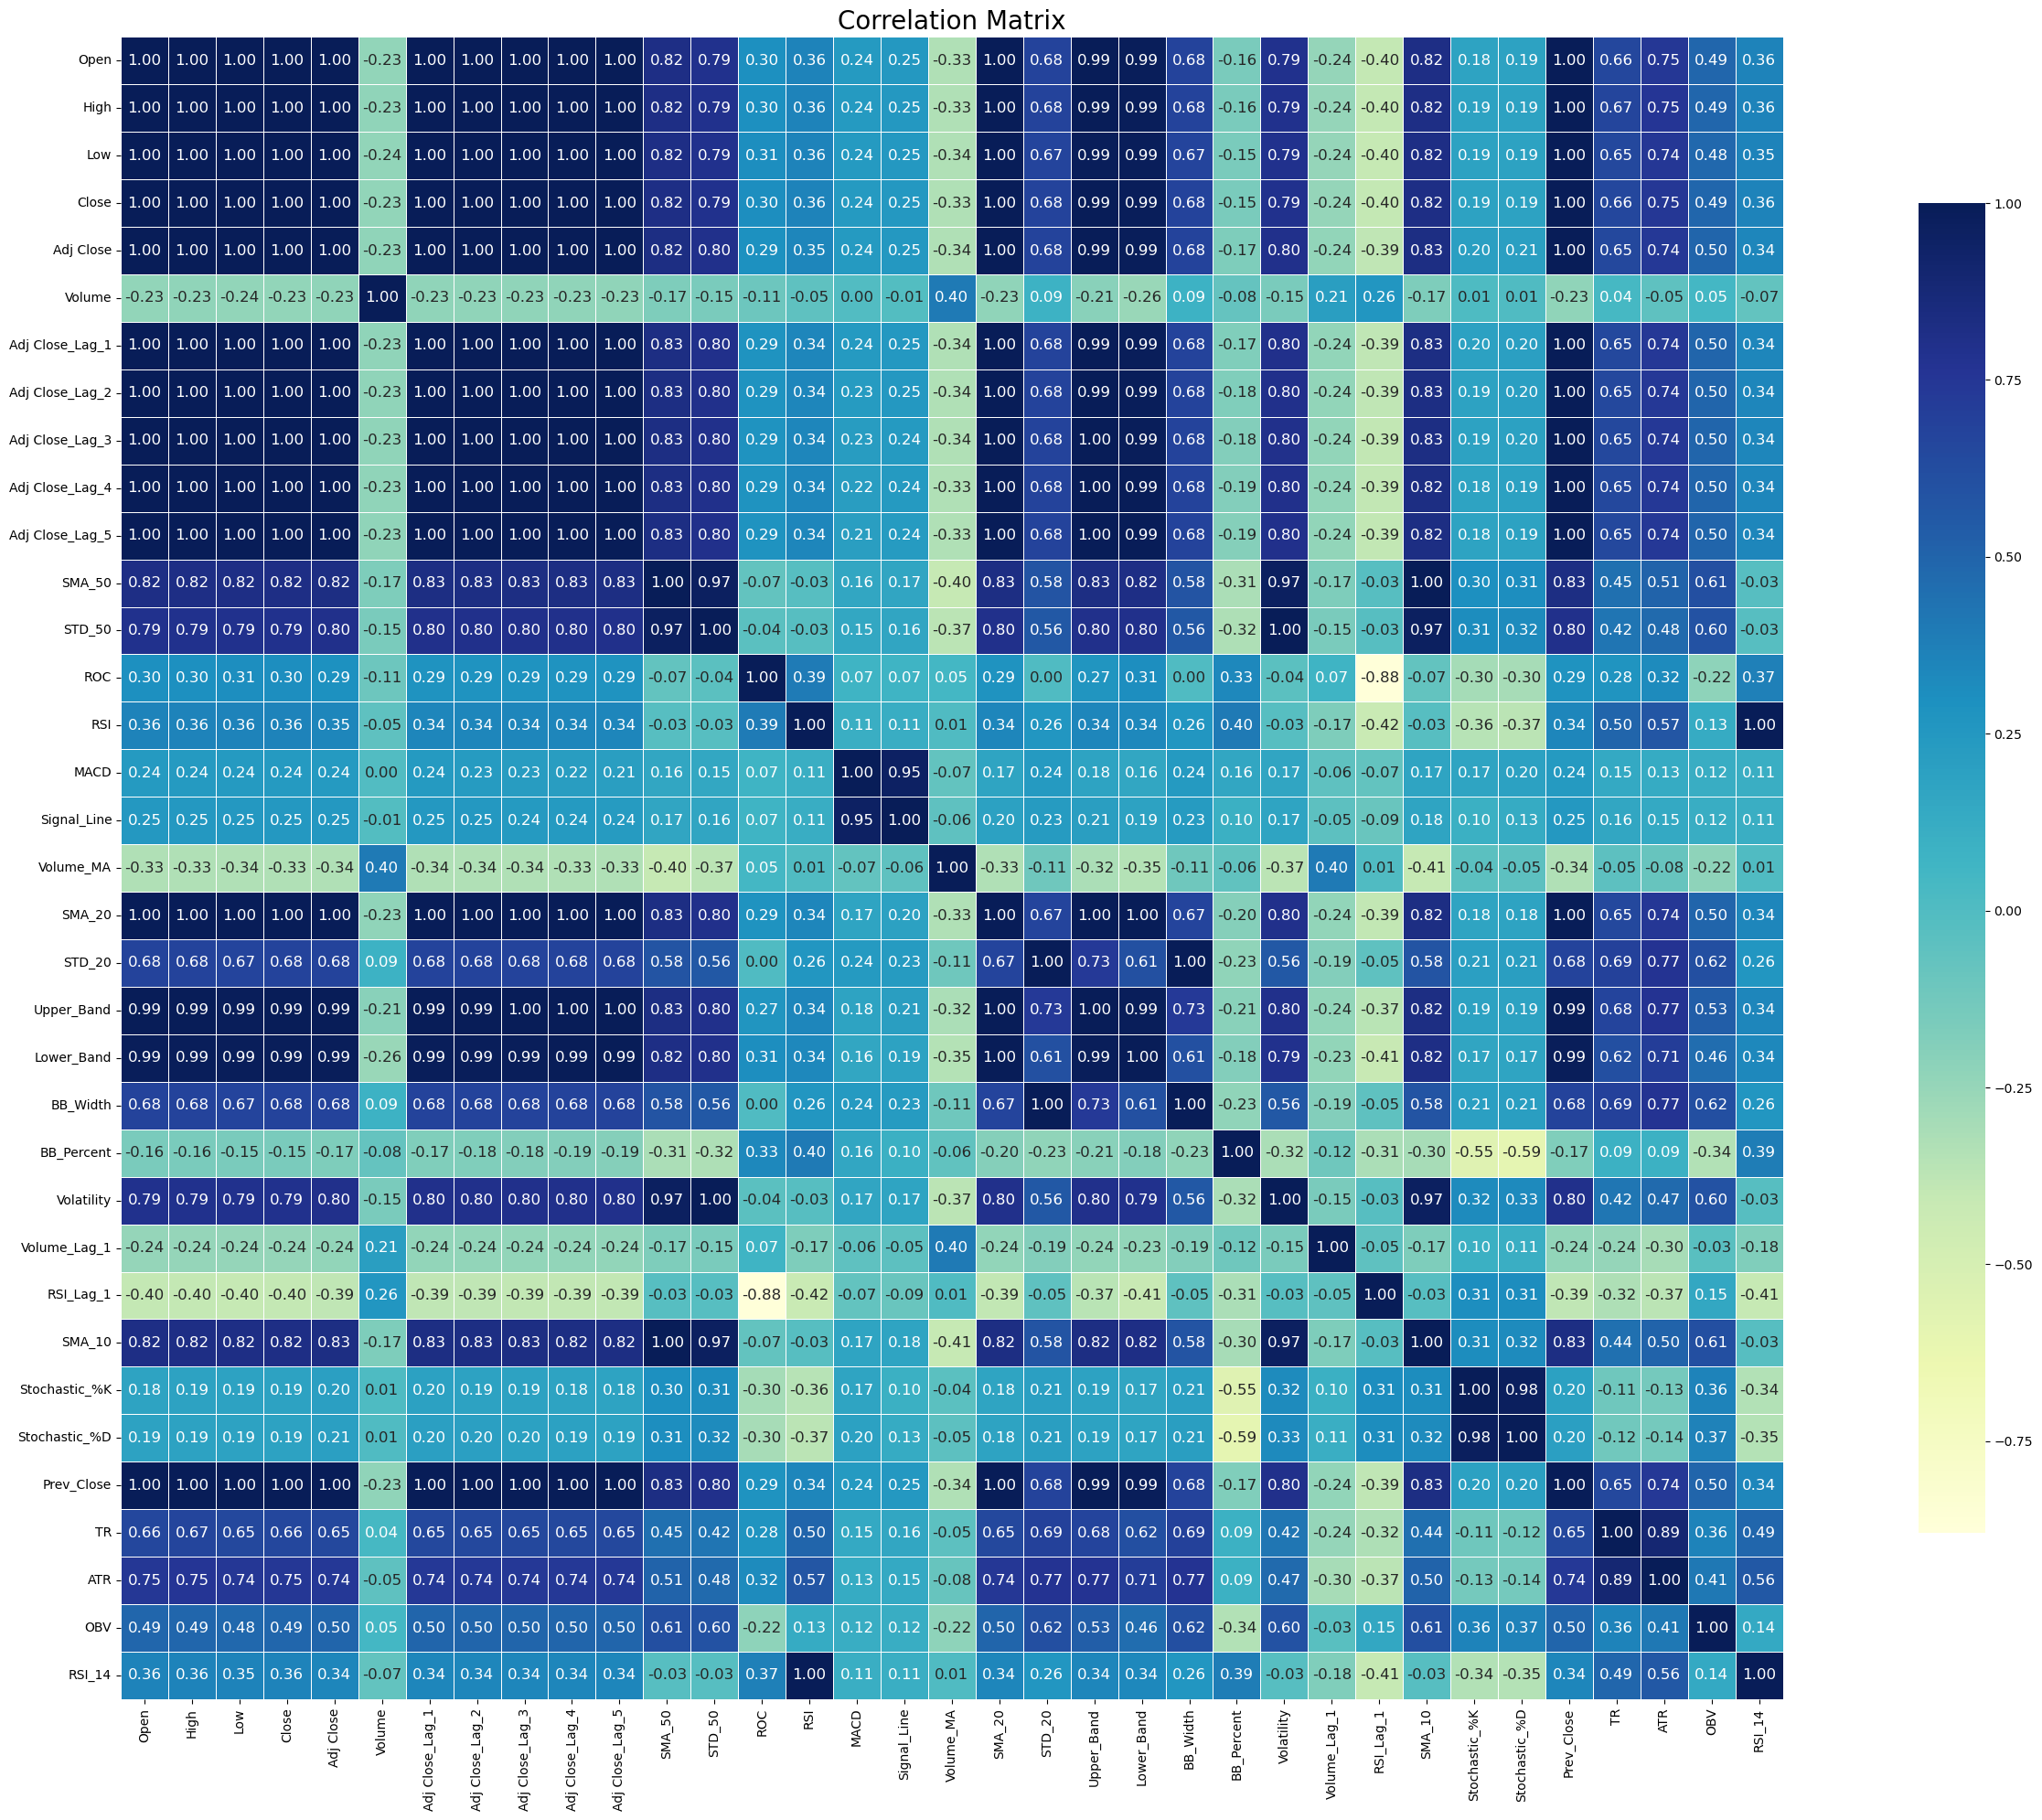

In [92]:
# Correlation Matrix
data_cleaned = data.drop(columns=['Ticker', 'Date'])

corr_matrix = data_cleaned.corr()

plt.figure(figsize=(30,20))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f', 
            linewidths=0.5, annot_kws={"size": 12}, cbar_kws={'shrink': 0.8}, square=True)
plt.title('Correlation Matrix', fontsize=20)

plt.tight_layout()

plt.show()


In [93]:
# This code identifies and visualizes the top correlated features with the target variable

Top positively correlated features with Adj Close
Adj Close          1.000000
Close              0.999671
High               0.999491
Low                0.999345
Prev_Close         0.999263
Adj Close_Lag_1    0.999263
Open               0.999188
Adj Close_Lag_2    0.998560
Adj Close_Lag_3    0.997870
Adj Close_Lag_4    0.997206
Name: Adj Close, dtype: float64

Top negatively correlated features with Adj Close
ROC              0.287983
Signal_Line      0.246954
MACD             0.240709
Stochastic_%D    0.206919
Stochastic_%K    0.202601
BB_Percent      -0.169566
Volume          -0.229069
Volume_Lag_1    -0.240692
Volume_MA       -0.335706
RSI_Lag_1       -0.385503
Name: Adj Close, dtype: float64


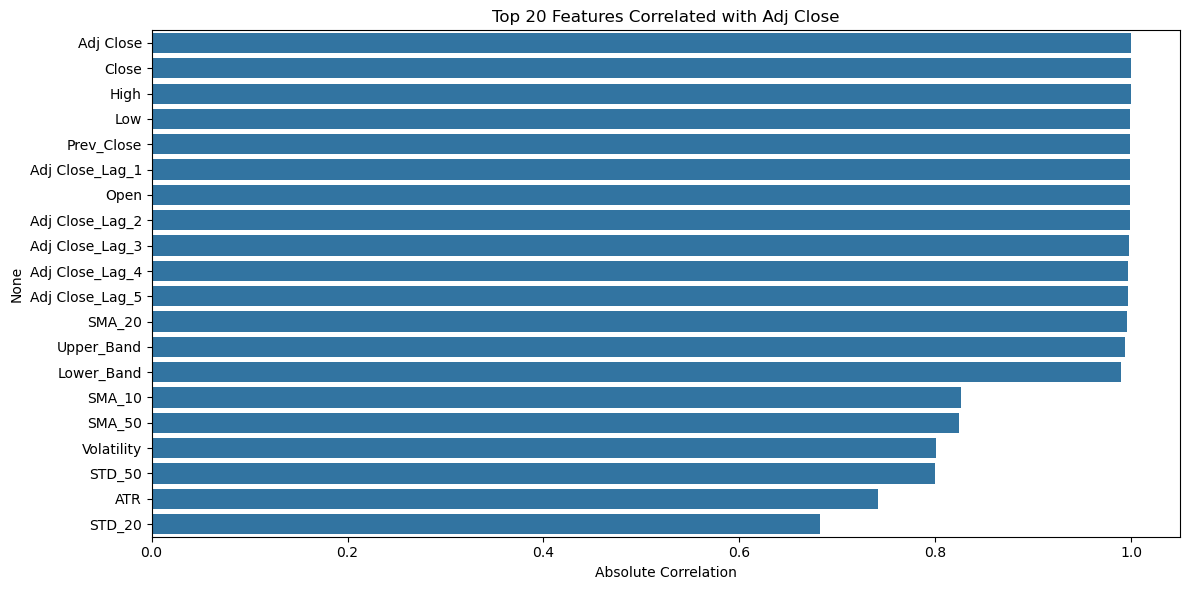

In [94]:
import seaborn as sns


data_cleaned = data.drop(columns=['Ticker', 'Date'], errors='ignore')

target = 'Adj Close'  # or 'Close' based on your model
correlation = data_cleaned.corr()[target].sort_values(ascending=False)

print("Top positively correlated features with", target)
print(correlation.head(10))

print("\nTop negatively correlated features with", target)
print(correlation.tail(10))

# Optional: plot the top N correlations visually
plt.figure(figsize=(12, 6))
sns.barplot(x=correlation.abs().sort_values(ascending=False).head(20).values,
            y=correlation.abs().sort_values(ascending=False).head(20).index)
plt.title(f'Top 20 Features Correlated with {target}')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()


In [95]:
print(data.head())
print(data.columns)

          Date Ticker       Open       High        Low      Close  Adj Close  \
120 2015-02-06   AAPL  30.004999  30.062500  29.612499  29.732500  26.560364   
121 2015-02-06   AMZN  18.743500  18.799500  18.550501  18.714001  18.714001   
122 2015-02-06  GOOGL  26.550501  27.011000  26.432501  26.694000  26.566984   
123 2015-02-06   MSFT  42.680000  42.790001  42.150002  42.410000  36.344292   
124 2015-02-06   TSLA  14.800000  14.893333  14.433333  14.490667  14.490667   

        Volume  Adj Close_Lag_1  Adj Close_Lag_2  ...  Volume_Lag_1  \
120  174826400        26.785923        26.596094  ...    52843500.0   
121   77848000        18.694500        18.237499  ...   174826400.0   
122   42938000        26.365448        26.179836  ...    77848000.0   
123   34616600        36.378586        35.855827  ...    42938000.0   
124   48658500        14.732667        14.570000  ...    34616600.0   

     RSI_Lag_1     SMA_10  Stochastic_%K  Stochastic_%D  Prev_Close        TR  \
120  46.575

In [96]:
# Drop columns that are not needed for the model
columns_to_drop = [ 'Close', 'Adj Close_Lag_2', 'Adj Close_Lag_3', 'Adj Close_Lag_4', 'Adj Close_Lag_5']
data_cleaned = data.drop(columns=columns_to_drop)

print(data_cleaned.columns)


Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Adj Close', 'Volume',
       'Adj Close_Lag_1', 'SMA_50', 'STD_50', 'ROC', 'RSI', 'MACD',
       'Signal_Line', 'Volume_MA', 'SMA_20', 'STD_20', 'Upper_Band',
       'Lower_Band', 'BB_Width', 'BB_Percent', 'Volatility', 'Volume_Lag_1',
       'RSI_Lag_1', 'SMA_10', 'Stochastic_%K', 'Stochastic_%D', 'Prev_Close',
       'TR', 'ATR', 'OBV', 'RSI_14'],
      dtype='object')


In [97]:
#Encoding

In [98]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(sparse_output=False), ['Ticker'])],
    remainder="passthrough"
)

encoded_array = ct.fit_transform(data_cleaned)
encoded_columns = ct.named_transformers_['encoder'].get_feature_names_out(['Ticker'])
all_columns = list(encoded_columns) + [col for col in data_cleaned.columns if col != 'Ticker']
data_encoded_df = pd.DataFrame(encoded_array, columns=all_columns, index=data_cleaned.index)


In [99]:
# Convert 'Date' to datetime format, normalize it as numerical days, and sort chronologically for time-series data
data_encoded_df['Date'] = pd.to_datetime(data_encoded_df['Date'])
data_encoded_df['Date'] = (data_encoded_df['Date'] - data_encoded_df['Date'].min()).dt.days
data_encoded_df = data_encoded_df.sort_values(by='Date')


In [100]:
#Train-Test Split with Scikit-Learn

In [101]:
from sklearn.model_selection import train_test_split

X = data_encoded_df.drop(columns=['Adj Close'])
y = data_encoded_df['Adj Close']


In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [103]:
#Scaling

In [104]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))



In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



def create_sequences(data, targets, n_time_steps):
    X_seq, y_seq = [], []
    for i in range(n_time_steps, len(data)):
        X_seq.append(data[i - n_time_steps:i])
        y_seq.append(targets[i])
    return np.array(X_seq), np.array(y_seq)


n_time_steps = 10


X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_time_steps)


print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
test_indexes = X_test.index[n_time_steps:]
test_data = data.loc[test_indexes, ['Date', 'Ticker']].reset_index(drop=True)





X_train_seq shape: (9958, 10, 35)
y_train_seq shape: (9958, 1)
X_test_seq shape: (2482, 10, 35)
y_test_seq shape: (2482, 1)


In [106]:
# Starting model lstm

In [107]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 50)              │          17,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,451 (146.29 KB)

 Trainable params: 37,451 (146.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0191 - val_loss: 0.0441 - learning_rate: 1.0000e-04
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0125 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0105 - val_loss: 0.0368 - learning_rate: 1.0000e-04
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0094 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0092 - val_loss: 0.0317 - learning_rate: 1.0000e-04
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0082 - val_loss: 0.0284 - learning_rate: 1.0000e-04
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0080 - val_loss: 0.0273 - learning_rate: 1.0000e-04
Epoch 8/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0079 - val_loss: 0.0264 - learning_rate: 1.0000e-04
Epoch 9/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0073 - val_loss: 0.0253 - 

In [108]:
# 1. Predict
y_pred = model.predict(X_test_seq)

# 2. Prepare dates
test_dates = data_encoded_df['Date'].iloc[len(X_train):].reset_index(drop=True)
plot_dates = test_dates[n_time_steps:].reset_index(drop=True)

# 3. Inverse transform (rescale) predictions and actual values
y_test_inverse = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# 4. Create pandas Series
y_test_rescaled = pd.Series(y_test_inverse, name='Actual')
y_pred_rescaled = pd.Series(y_pred_inverse, name='Predicted')

# 5. Check shapes
print("plot_dates shape:", plot_dates.shape)
print("y_test_seq shape:", y_test_seq.shape)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
plot_dates shape: (2482,)
y_test_seq shape: (2482, 1)


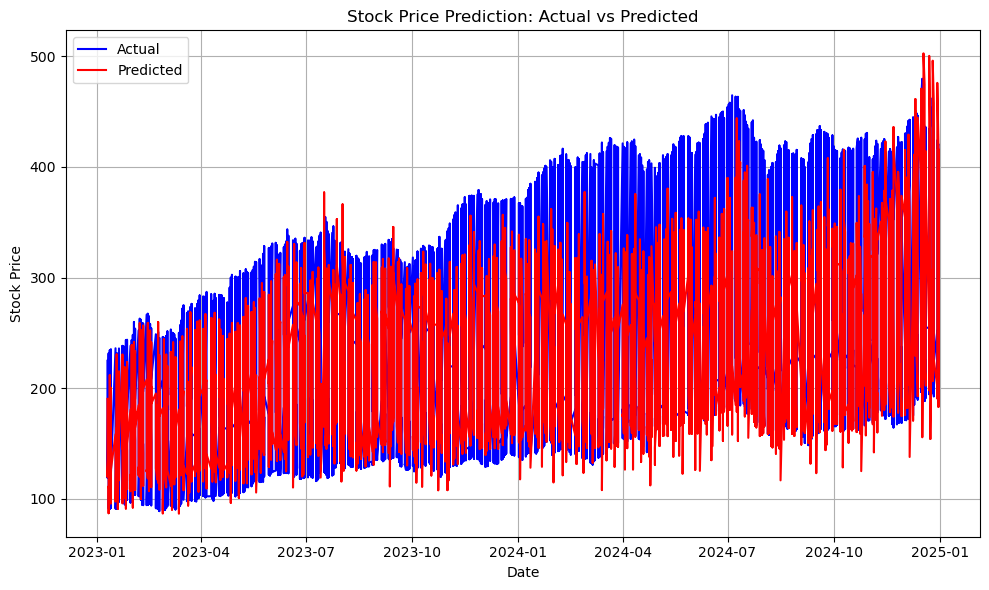

In [109]:
plot_dates = data_cleaned['Date'][len(data_cleaned) - len(y_pred_rescaled):].reset_index(drop=True)

# Plot the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(plot_dates, y_test_rescaled, label='Actual', color='blue')
plt.plot(plot_dates, y_pred_rescaled, label='Predicted', color='red')
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
# Checking the model's accuracy

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test_seq)

rmse = mean_squared_error(y_test_seq, y_pred, squared=False)
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test_seq, y_pred)
print(f"MAE: {mae}")

r2 = r2_score(y_test_seq, y_pred)
print(f"R²: {r2}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 0.13055858012755983
MAE: 0.09859161872352717
R²: 0.678018532499875


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [113]:
# Plotting actual vs predicted stock prices for each company

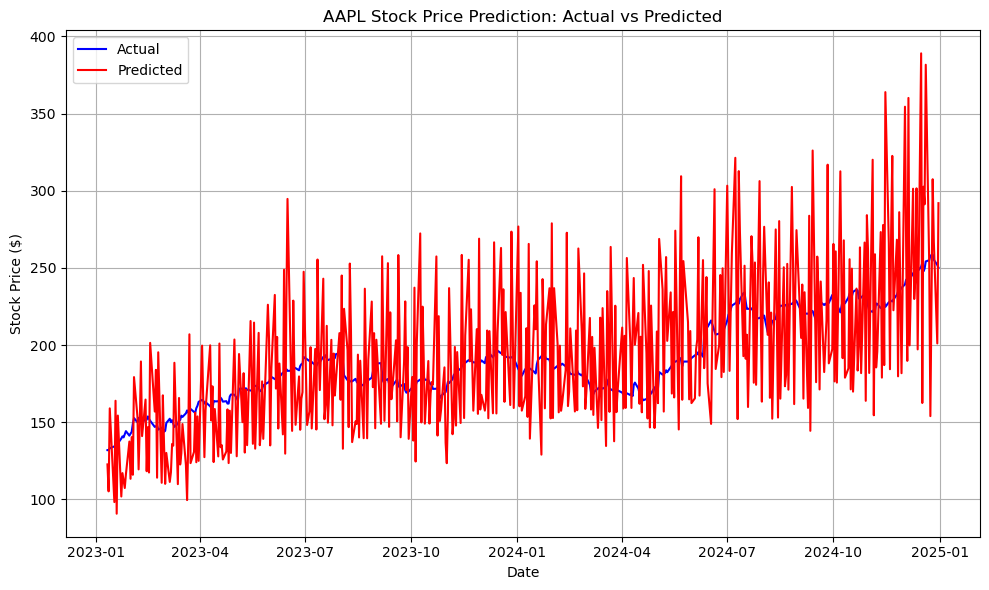

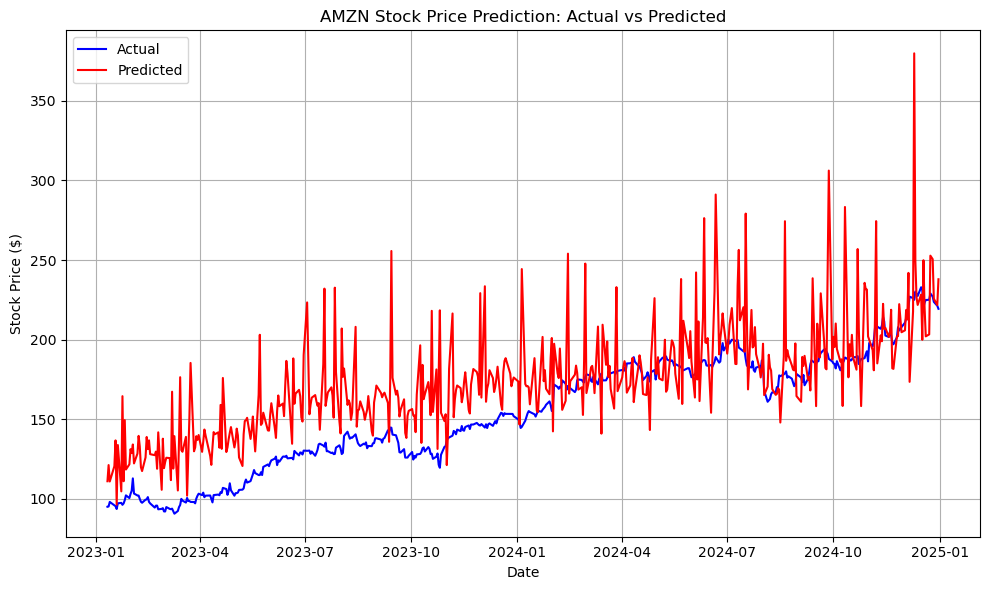

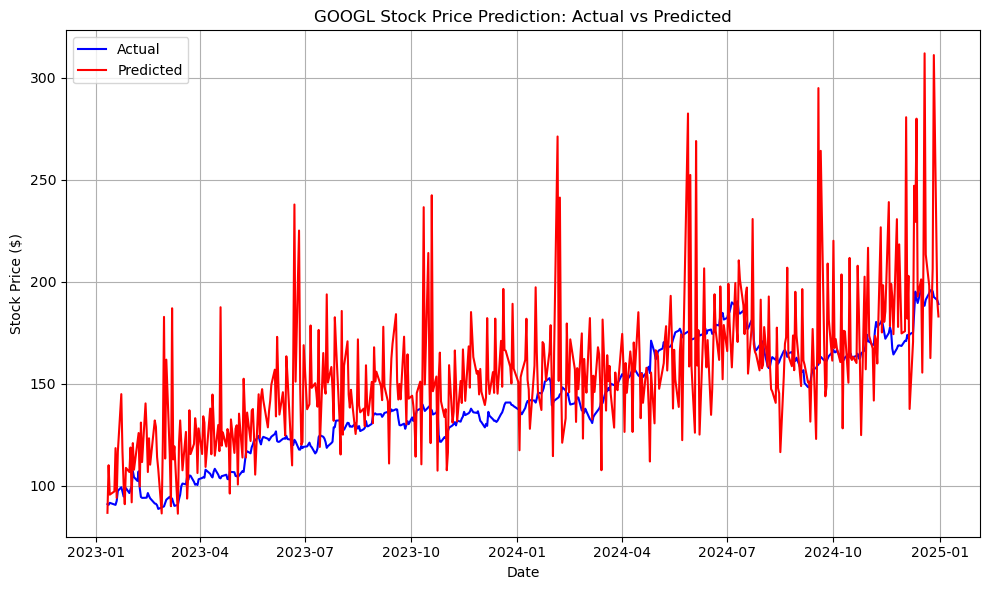

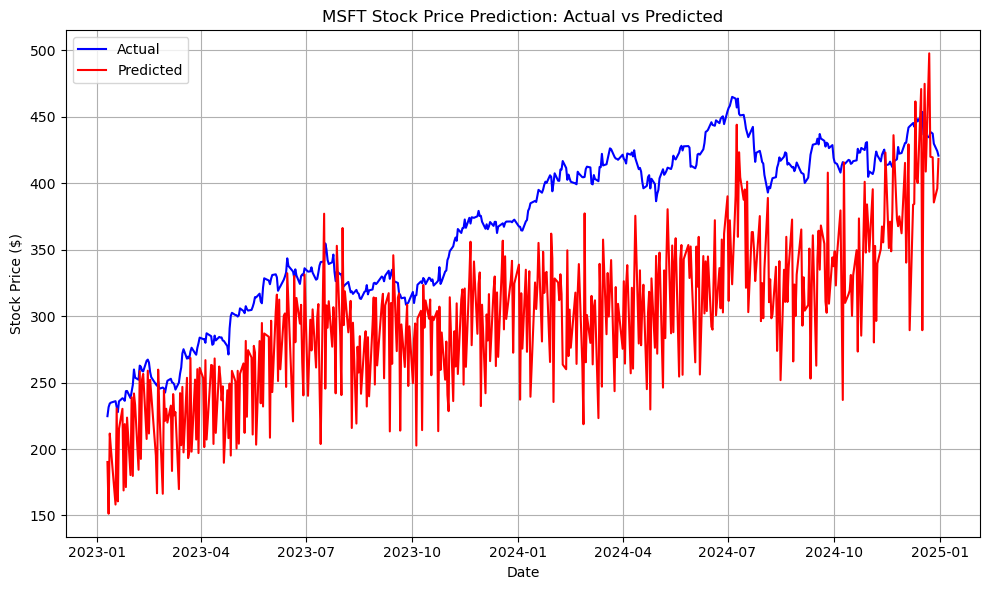

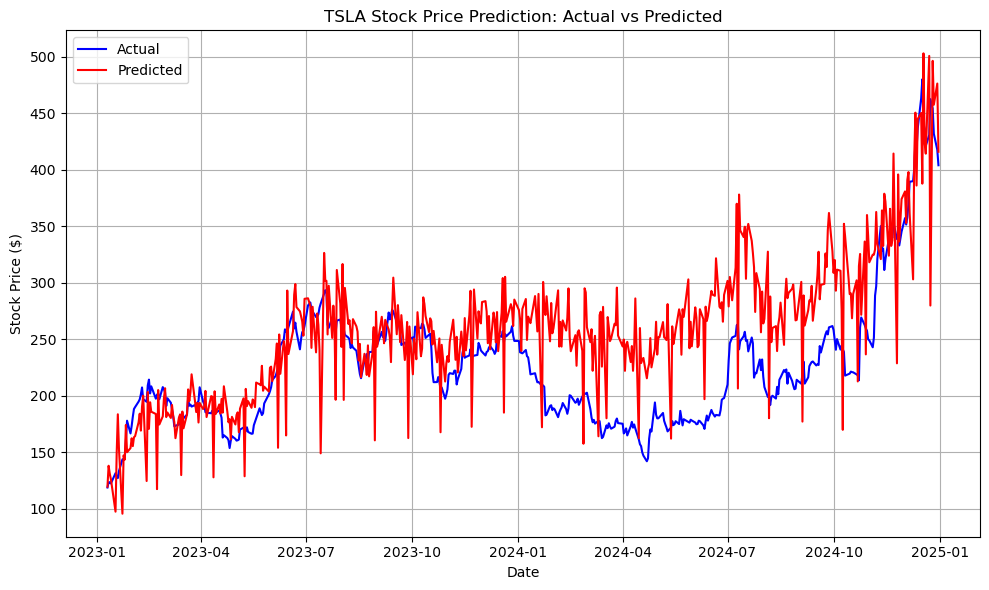

In [114]:
import matplotlib.pyplot as plt

def plot_stock_prediction(company, actual, predicted, dates):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, actual, label='Actual', color='blue')
    plt.plot(dates, predicted, label='Predicted', color='red')
    plt.title(f'{company} Stock Price Prediction: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Combine everything into one DataFrame for easier filtering
results_df = test_data.copy()
results_df['Actual'] = y_test_rescaled  # Directly assign the numpy array
results_df['Predicted'] = y_pred_rescaled  # Directly assign the numpy array

# List of companies to visualize
companies = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA']

# Loop through each company and plot their individual predictions
for company in companies:
    # Filter the results DataFrame
    company_df = results_df[results_df['Ticker'] == company]

    # Extract values
    actual_values = company_df['Actual']
    predicted_values = company_df['Predicted']
    dates = company_df['Date']

    # Plot the result
    plot_stock_prediction(company, actual_values, predicted_values, dates)


In [115]:
# Installing Plotly and Dash for interactive data visualization and web applications
!pip install plotly dash


In [116]:
# Dash web application to visualize stock price predictions for different companies with interactive dropdown and plotly charts

In [117]:
import dash
from dash import dcc, html
import plotly.graph_objs as go
import pandas as pd
import numpy as np


np.random.seed(42)

companies = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA']
dates = pd.date_range(start='2023-01-01', end='2025-01-01', freq='B').tolist()  # Business days between 2023 and 2025


data = []
for company in companies:
    actual = np.random.randint(100, 110, size=len(dates))  
    predicted = actual + np.random.randint(-2, 2, size=len(dates)) 
    data.append(pd.DataFrame({
        'Date': dates,
        'Ticker': [company] * len(dates),
        'Actual': actual,
        'Predicted': predicted
    }))

# Concatenate all company data into one DataFrame
results_df = pd.concat(data, ignore_index=True)

def create_stock_plot(company_data, company):
    trace_actual = go.Scatter(
        x=company_data['Date'], y=company_data['Actual'],
        mode='lines', name='Actual', line=dict(color='blue')
    )
    trace_predicted = go.Scatter(
        x=company_data['Date'], y=company_data['Predicted'],
        mode='lines', name='Predicted', line=dict(color='red')
    )

    layout = go.Layout(
        title=f'{company} Stock Price Prediction: Actual vs Predicted',
        xaxis={'title': 'Date'},
        yaxis={'title': 'Stock Price ($)'},
        template='plotly_dark'
    )

    return {'data': [trace_actual, trace_predicted], 'layout': layout}

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Stock Price Prediction'),
    dcc.Dropdown(
        id='company-dropdown',
        options=[{'label': company, 'value': company} for company in companies],
        value=companies[0],
        style={'width': '50%'}
    ),
    dcc.Graph(id='stock-price-graph')
])

@app.callback(
    dash.dependencies.Output('stock-price-graph', 'figure'),
    [dash.dependencies.Input('company-dropdown', 'value')]
)
def update_graph(selected_company):
  
    company_data = results_df[results_df['Ticker'] == selected_company]
    
    return create_stock_plot(company_data, selected_company)

if __name__ == '__main__':
     app.run(debug=True)
